In [1]:
%cd ../..
%load_ext autoreload

%autoreload 2

/home/giacomowsl/Projects/sinergia/emplusvault


In [64]:
import os
import json
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from rts.features.pose import compute_human_angles, reshape_keypoints
import rts.features.pose as pose
import umap
import cv2

In [65]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


# Load poses

## From jsonlines files

In [66]:
poses_folder = "data/test_poses/"
poses_jl = [poses_folder + f for f in os.listdir(poses_folder)]
poses = []
for pose_json in poses_jl:
    extracted_data = pose.extract_frame_data(pose_json, 0.5)
    if len(extracted_data.keys()) > 0:
        pose_exp = [[{"frame_number":k, "angle_vec":angle, "keypoints":keypoint, "bbox":bbox} for angle,keypoint,bbox in zip(v["angle_vec"], v["keypoints"], v["bbox"])] for k,v in extracted_data.items()]
        pose_exp = [item for sublist in pose_exp for item in sublist]
        [p.update({"video_name":pose_json.split("/")[-1].split(".")[0]}) for p in pose_exp]
        poses.extend(pose_exp)

print(len(poses))

14311


# Visualize poses

In [5]:
KEYPOINTS_NAMES = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", 
                   "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", 
                   "left_wrist", "right_wrist", "left_hip", "right_hip", 
                   "left_knee", "right_knee", "left_ankle", "right_ankle"]

In [6]:
CONNECTIONS = [
    ("nose", "left_eye"),
    ("nose", "right_eye"),
    ("left_eye", "left_ear"),
    ("right_eye", "right_ear"),
    ("left_shoulder", "right_shoulder"),
    ("left_shoulder", "left_elbow"),
    ("right_shoulder", "right_elbow"),
    ("left_elbow", "left_wrist"),
    ("right_elbow", "right_wrist"),
    ("left_hip", "right_hip"),
    ("left_hip", "left_knee"),
    ("right_hip", "right_knee"),
    ("left_knee", "left_ankle"),
    ("right_knee", "right_ankle"),
    ("left_shoulder", "left_hip"),
    ("right_shoulder", "right_hip")
]

In [7]:
def format_keypoints_to_read(keypoints):
    return {k:v for k,v in zip(KEYPOINTS_NAMES, keypoints)}

In [8]:
format_keypoints_to_read(poses[3]["keypoints"])

{'nose': (880.54, 140.84, 0.69),
 'left_eye': (882.94, 138.21, 0.75),
 'right_eye': (877.96, 138.41, 0.7),
 'left_ear': (887.71, 138.89, 0.88),
 'right_ear': (873.91, 138.78, 0.81),
 'left_shoulder': (894.85, 152.73, 0.98),
 'right_shoulder': (868.59, 153.44, 1.0),
 'left_elbow': (899.79, 169.95, 0.9),
 'right_elbow': (860.65, 173.0, 0.97),
 'left_wrist': (898.09, 184.84, 0.84),
 'right_wrist': (866.44, 186.42, 0.92),
 'left_hip': (889.55, 188.73, 0.96),
 'right_hip': (873.23, 188.33, 0.98),
 'left_knee': (901.55, 200.29, 0.81),
 'right_knee': (868.17, 201.51, 0.72),
 'left_ankle': (0.0, 0.0, 0.0),
 'right_ankle': (0.0, 0.0, 0.0)}

In [9]:
sequences_folder = "/mnt/g/ioc/sequences/"

def get_frame(video_name, frame_number):
    video_path = [f for f in os.listdir(sequences_folder + video_name) if f.endswith(".mp4")][0]
    cap = cv2.VideoCapture(sequences_folder + video_name + "/" + video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [12]:
def draw_pose(pose, ax = None, cut=True, threshold=0.1):
    keypoints = pose["keypoints"]

    # Do not draw non-detected keypoints
    #connections = [c for c in connections if keypoints[KEYPOINTS_NAMES.index(c[0])][2] > threshold and keypoints[KEYPOINTS_NAMES.index(c[1])][2] > threshold]
    #keypoints = [k for k in keypoints if k[2] > threshold]
    
    frame = get_frame(pose["video_name"], pose["frame_number"])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    ax.imshow(frame)
    ax.scatter([k[0] for k in keypoints if k[2] > threshold], [k[1] for k in keypoints if k[2] > threshold], s=10)
    for c in CONNECTIONS:
        k1 = keypoints[KEYPOINTS_NAMES.index(c[0])]
        k2 = keypoints[KEYPOINTS_NAMES.index(c[1])]
        if k1[2] > threshold and k2[2] > threshold:
            ax.plot([k1[0], k2[0]], 
                    [k1[1], k2[1]], 
                    linewidth=1, color='black')
        
    # cut frame to bbox
    bbox = pose["bbox"]
    if cut:
        ax.set_xlim(int(bbox[0]),int(bbox[0] + bbox[2]))
        ax.set_ylim(int(bbox[1] + bbox[3]), int(bbox[1]))

    ax.axis("off")
    ax.set_aspect('equal')
    plt.tight_layout()

    return ax


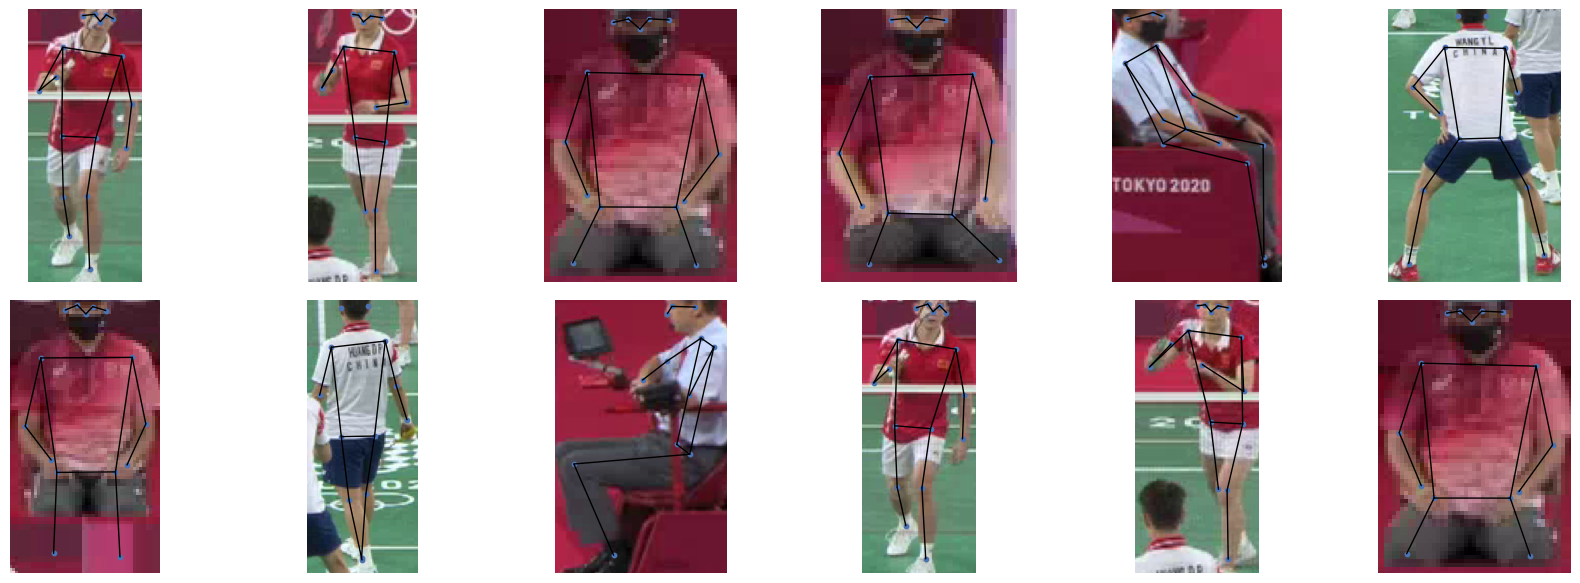

In [14]:
# create a grid of subplots
nrows = 2
ncols = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))
axs = axs.flatten()
# iterate over the poses and draw each pose in a subplot
for i, pose in enumerate(poses[:nrows * ncols]):
    draw_pose(pose, ax = axs[i], cut = True)

plt.show()


# Add metadata

In [54]:
from rts.utils import dataframe_from_hdf5

archiva_path = "/mnt/g/ioc/data/"
data = dataframe_from_hdf5(archiva_path, "metadata")

In [69]:
poses_df = pd.DataFrame(poses)
poses_df = pd.merge(poses_df, data[["seq_id", "sport"]], left_on="video_name", right_on="seq_id")
poses_df.head()

,frame_number,angle_vec,keypoints,bbox,video_name,seq_id,sport
0,0,"[0.8966219822240752, 0.12351974652222208, 0.93...","[(561.54, 243.19, 0.68), (564.89, 239.32, 0.7)...","[520.16, 236.84, 65.75, 155.89]",MDA42762820,MDA42762820,Badminton
1,0,"[0.47225142455350166, 0.019543982729455157, 0....","[(682.45, 233.91, 0.91), (686.25, 230.79, 0.95...","[653.96, 227.09, 57.25, 146.46]",MDA42762820,MDA42762820,Badminton
2,0,"[0.7299774586886015, 0.7779588370664416, 0.0, ...","[(373.86, 139.99, 0.75), (376.09, 137.43, 0.76...","[350.89, 135.6, 47.18, 68.36]",MDA42762820,MDA42762820,Badminton
3,0,"[0.874887830173097, 0.7476038746293181, 0.0, 0...","[(880.54, 140.84, 0.69), (882.94, 138.21, 0.75...","[856.13, 136.63, 50.63, 69.9]",MDA42762820,MDA42762820,Badminton
4,0,"[0.8483411499350413, 0.8139497219569558, 0.565...","[(94.36, 324.5, 0.56), (0.0, 0.0, 0.0), (90.02...","[70.34, 321.04, 82.27, 132.02]",MDA42762820,MDA42762820,Badminton


# Dimensionality Reduction

In [78]:
top_sports = poses_df.groupby("sport").count().sort_values("video_name", ascending=False).head(10).index.tolist()
top_sports_df = poses_df[poses_df["sport"].isin(top_sports)]
top_sports_df.shape

(11536, 9)

In [83]:
reducer = umap.UMAP(n_neighbors=1000, min_dist=0.3, metric='cosine')
embedding = reducer.fit_transform(top_sports_df["angle_vec"].tolist())
top_sports_df["umap_x"] = embedding[:,0]
top_sports_df["umap_y"] = embedding[:,1]

/tmp/ipykernel_32597/2657858174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sports_df["umap_x"] = embedding[:,0]
/tmp/ipykernel_32597/2657858174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sports_df["umap_y"] = embedding[:,1]


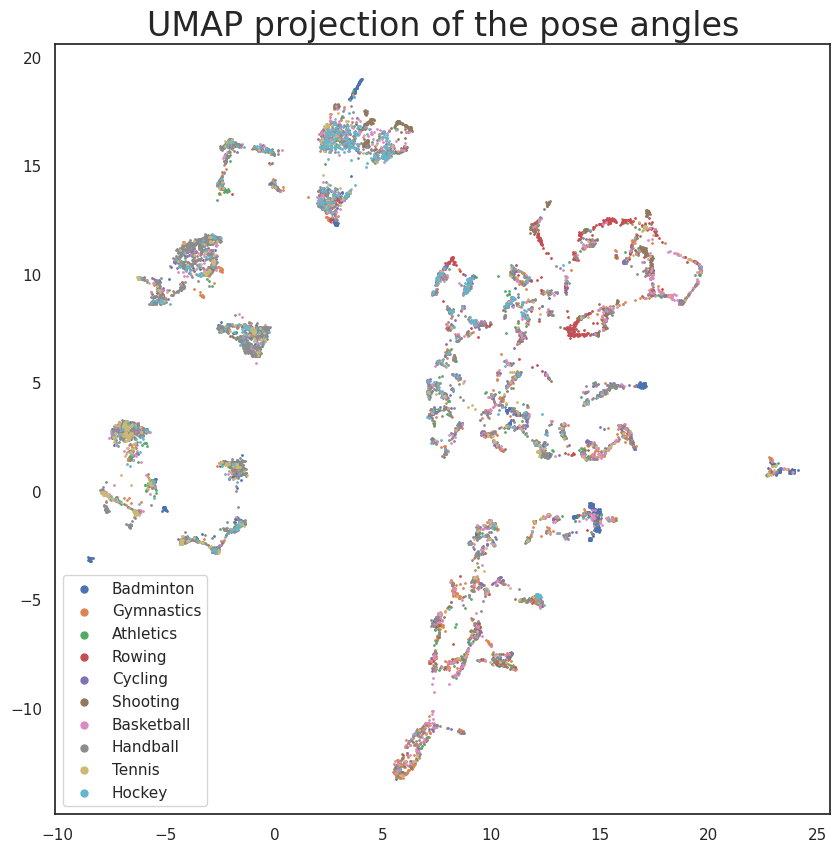

In [84]:
plt.figure(figsize=(10, 10))
for sport in top_sports_df["sport"].unique():
    plt.scatter(top_sports_df[top_sports_df["sport"] == sport]["umap_x"], 
                top_sports_df[top_sports_df["sport"] == sport]["umap_y"], 
                s= 1, label = sport)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(markerscale = 5)
plt.title('UMAP projection of the pose angles', fontsize=24)
plt.show()

## Bokeh plot

In [16]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, ImageURL
from bokeh.io import push_notebook
import base64
from io import BytesIO

output_notebook()

Loading BokehJS ...

In [24]:
def create_annotation_image(pose):
    fig, ax = plt.subplots(figsize=(6,6))
    draw_pose(pose, ax=ax, cut=True)
    buffer = BytesIO()
    fig.canvas.print_png(buffer)
    img_str = "data:image/png;base64," + base64.b64encode(buffer.getvalue()).decode('utf-8')
    plt.close(fig)
    return img_str


In [49]:
N_POSES = 500
EVERY_N = 10
embedded_images = [create_annotation_image(pose) for pose in poses[::EVERY_N][:N_POSES]]

In [52]:
reducer = umap.UMAP(n_neighbors=int(0.1 * N_POSES), min_dist=0.9, metric='cosine')
embedding = reducer.fit_transform([p["angle_vec"] for p in poses[::EVERY_N][:N_POSES]])

In [ ]:
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
from PIL import Image
import io

# Example 2D points
x = embedding[:, 0]
y = embedding[:, 1]

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(x=x, y=y, url=embedded_images))

# Output to notebook
output_notebook()

# Create a new plot
p = figure(width=1000, height=1000)


# Add images
p.image_url(url='url', x='x', y='y', source=source, w=0.5, h=0.5, anchor="center")

# Show the plot
handle = show(p, notebook_handle=True)
